# Creating GeoJSON for sotmus-analysis page 

Requirements: `geometry` attribute is parsable GeoJSON geometry

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

In [3]:
PLACE = "detroit"
DATA  = '../data/'+PLACE+'-heatmap-stats.data'

Ensure the header is correct: 

    feat.properties['@id'],
    feat.properties['@type'],
    feat.properties.highway,
    feat.properties.building,
    feat.properties.amenity,
    len,
    objArea,
    aA.join(","),
    aD.join(","),
    aM.join(","),
    version.properties['@user'],
    version.properties['@version'],
    version.properties['@minorVersion'],
    version.properties['@validSince'],
    version.properties['@validUntil'],
    JSON.stringify(version.geometry) || undefined

In [4]:
header = ['id',        
          'type',
          'highway',
          'building',
          'amenity',
          'length',
          'area',
          'aA',
          'aD',
          'aM',
          'user',
          'version',
          'minorVersion',
          'validSince',
          'validUntil',
          'center'
          'geometry']

In [5]:
df = pd.read_csv(DATA,names=header, sep='\t')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Calculate new columns and convert to Python objects

In [ ]:
df['date'] = df.validSince.apply(lambda x: pd.Timestamp(x*1000000000).date())
df.replace("false", np.NaN, inplace=True)
df.validUntil = df['validUntil'].astype(float)

In [ ]:
df.id.count(), df.id.nunique(), df.user.nunique(), df.query('version==1').id.count()

In [ ]:
df = df[df.geometry.notnull()]

In [ ]:
df.id.count(), df.id.nunique(), df.user.nunique(), df.query('version==1').id.count()

In [ ]:
df.head(3)

# Version 1: Export edits by Date Per Object:

In [204]:
for TYPE in ['building', 'highway','amenity']:
    featColl = {'type':'FeatureCollection','features':[]}
    for date, edits in df[df[TYPE].notnull()].groupby('date'):
        geometryColl = edits.geometry.apply(lambda x: json.loads(x))
        geojson = {
            'geometry':{'type':'GeometryCollection','geometries':list(geometryColl)},
            'type':"Feature",
            'properties': {'days_since_2005': (date - datetime.date(2005,1,1) ).days, 'edits':len(edits)}
        }
        featColl['features'].append(geojson)
    print("Finished", TYPE)

    json.dump(featColl, open("../docs/data/"+PLACE+"-"+TYPE+"-points.geojson",'w'))

Finished building
Finished highway
Finished amenity


# Version 2: Export more data (for tiling)

# Various Analyses Available for these files
## Unique Users overtime

In [179]:
allUsers = []
dates = {}
for idx, row in df.sort_values(by='validSince').iterrows():
    if row.user not in allUsers:
        if row.date in dates:
            dates[row.date]+=1
        else:
            dates[row.date]=1
        allUsers.append(row.user)
dates2 = []
for date, value in dates.items():
    dates2.append({'date':date, 'count':value})
unique_users_over_time = pd.DataFrame(dates2)

In [180]:
unique_users_over_time['cumulative'] = unique_users_over_time['count'].cumsum()

Text(0.5,0,'Year')

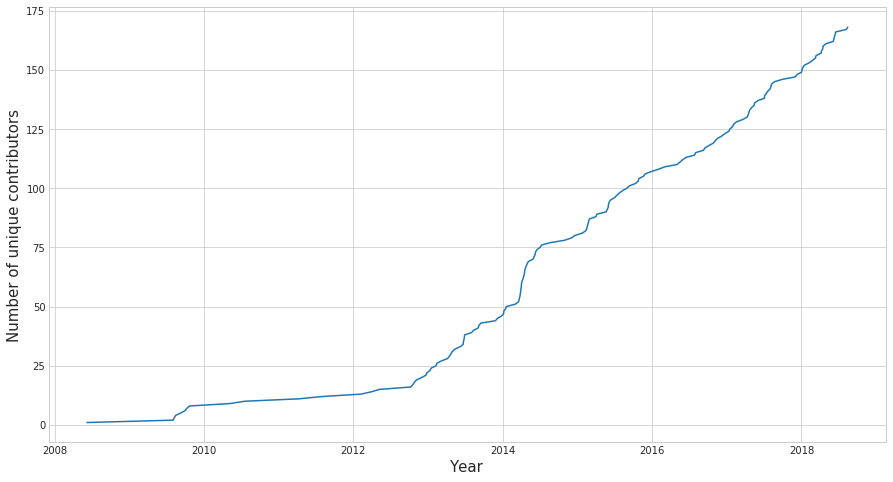

In [181]:
sns.set_style('whitegrid')
ax = unique_users_over_time.plot(x='date',y='cumulative',figsize=(15,8),legend=None)
ax.set_ylabel('Number of unique contributors', fontsize=15);
ax.set_xlabel('Year', fontsize=15)

# When were Tiger Tags Deleted?

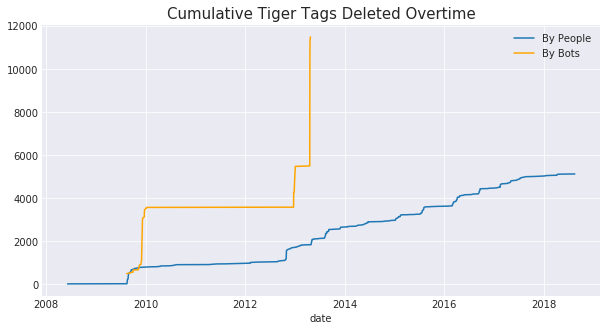

In [182]:
gb_dates_nobots = df[~df['user'].str.contains("bot")].groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique})
gb_dates_bots = df[df['user'].str.contains("bot")].groupby('date').aggregate({'id':pd.Series.count, 'user': pd.Series.nunique})
sns.set_style("darkgrid")
ax = gb_dates_nobots.id.cumsum().plot(figsize=(10,5))
gb_dates_bots.id.cumsum().plot(color='orange',ax=ax)
ax.set_title("Cumulative Tiger Tags Deleted Overtime", fontsize=15)
ax.legend(['By People','By Bots']);